In [1]:
# Cài đặt
!pip install pymssql
!pip install pyodbc

#import thu vien
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
import seaborn as sns

# Connection information
server = '45.117.83.230'
port = 1433
username = 'Student1'
password = '@Mindxdream2023'
database = 'OLIST'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 2.1 MB/s eta 0:00:00


In [2]:
# Connect to the database sellers
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
try:
  # Query to select data
  query = "SELECT * FROM dbo.sellers"
  # Execute the query and read the results into a Pandas DataFrame
  df = pd.read_sql(query, connection)
finally:
  # Ensure to close the connection after finishing the work
  connection.close()

# Connect to the database orders
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.orders"
df_order = pd.read_sql(query, connection)

# Connect to the database customer
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.customers"
df_customer = pd.read_sql(query, connection)

# Connect to the database order_items
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.order_items"
df_order_items = pd.read_sql(query, connection)

# Connect to the database geolocation
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.geolocation"
df_geolocation = pd.read_sql(query, connection)

# Connect to the database order_payments
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.order_payments"
df_order_payment = pd.read_sql(query, connection)

# Connect to the database order_reviews
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.order_reviews"
df_order_review = pd.read_sql(query, connection)

# Connect to the database product_category_name_translation
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.product_category_name_translation"
df_product_category_name_translation = pd.read_sql(query, connection)

# Connect to the database products
connection = pymssql.connect(server=server, port=port, user=username, password=password, database=database)
query = "SELECT * FROM dbo.products"
df_product = pd.read_sql(query, connection)

<ipython-input-2-a6e6b8e9db4e>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
<ipython-input-2-a6e6b8e9db4e>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order = pd.read_sql(query, connection)
<ipython-input-2-a6e6b8e9db4e>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql(query, connection)
<ipython-input-2-a6e6b8e9db4e>:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection.

#**PHÂN LOẠI KHÁCH HÀNG BẰNG RFM**

**Câu 1:** *Nhóm khách hàng Best Customers có đặc điểm như thế nào? Số lượng?*

**Câu 2:** *Đâu là các khách hàng rời bỏ? Số lượng?*

(Quy định lấy cột order_purchase_timestamp làm chuẩn tính toán liên quan đến thời gian)

In [3]:
# Merge 2 bảng df_order và df_order_payment để tính các chỉ số RFM
df_join = pd.merge(df_order, df_order_payment, how='inner',on='order_id')[['order_id','customer_id','order_purchase_timestamp','payment_value','order_approved_at','order_delivered_customer_date']]

In [4]:
# Tính RFM
current_date = df_join['order_purchase_timestamp'].max()
## Tính Recency, Frequency, Monetary với mỗi customer_id
rfm_df = df_join.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - pd.to_datetime(x).max()).days, # Recency
    'order_id': 'nunique',  # Frequency
    'payment_value': 'sum'  # Monetary
}).reset_index()
rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

## Sắp xếp thứ tự cho 3 cột Recency, Frequency, Monetary
rfm_df['R_rank'] = rfm_df['Recency'].rank(pct=True)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(pct=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(pct=True)

In [5]:
## Phân tách giá trị ở mỗi cột và cho điểm
rfm_df['R_quartile'] = pd.cut(rfm_df['R_rank'], 5, labels=[5,4,3,2,1])
rfm_df['F_quartile'] = pd.cut(rfm_df['F_rank'], 5, labels=[1,2,3,4,5])
rfm_df['M_quartile'] = pd.cut(rfm_df['M_rank'], 5, labels=[1,2,3,4,5])

## Tính điểm RFM
rfm_df['RFM_Score'] = rfm_df['R_quartile'].astype(int)*100 + rfm_df['F_quartile'].astype(int)*10 + rfm_df['M_quartile'].astype(int)

## Bảng phân loại
segment_map = {
    'High customer': [555, 554, 544, 545, 454, 455, 445,
                      543, 444, 435, 355, 354, 345, 344, 335,
                      553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323,],

    'Potential customer': [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313,
                          512, 511, 422, 421, 412, 411, 311,
                          331, 321, 312, 221, 213, 231, 241, 251],

    'Customers requiring attention': [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124,
                                      535, 534, 443, 434, 343, 334, 325, 324,
                                      155,154, 144, 214, 215, 115, 114, 113],

    'Low customer': [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211,
                     111, 112, 121, 131, 141, 151],
}

## Function phân loại khách hàng dựa vào điểm RFM
def map_segment(score):
    for segment, scores in segment_map.items():
        if score in scores:
            return segment
    return 'Other'
## Phân loại khách hàng
rfm_df['Segment'] = rfm_df['RFM_Score'].apply(map_segment)

[Text(0, 0, '35831'),
 Text(0, 0, '35302'),
 Text(0, 0, '20475'),
 Text(0, 0, '7831')]

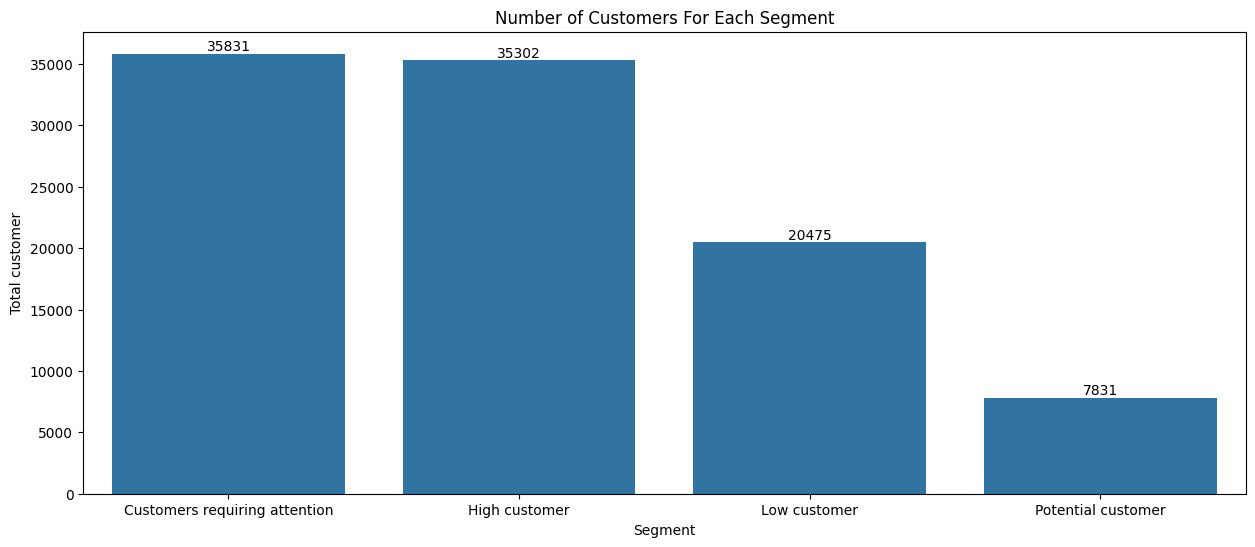

In [6]:
# Tạo bảng đếm số lượng khách hàng với mỗi tệp khách hàng
segment_count = rfm_df.groupby('Segment').agg(Total_customer = ('customer_id','count')).reset_index()

# Vẽ chart thể hiện số lượng user ở mỗi tệp phân loại
plt.figure(figsize=(15,6))
plt.title('Number of Customers For Each Segment')
plt.xlabel('Segment')
plt.ylabel('Total customer')
count_of_user = sns.barplot(data=segment_count, x='Segment', y='Total_customer', errorbar = None)
count_of_user.bar_label(count_of_user.containers[0])

**Các khía cạnh giúp khắc họa chân dung của Best Customer (High Customer):**

1. Số lượng đơn hàng trung bình (merge df_join và rfm_df)
2. Số tiền mua hàng trung bình (dùng bảng ở phần 1)
3. High Customer họ thường phân bổ chủ yếu ở đâu (merge tiếp với df_customer)
6. Số điểm trung bình mà họ đánh giá (xem họ có khó tính hay không?, merge tiếp với df_order_review)
7. Customer Lifetime Value của High Customer


In [7]:
# Tạo bảng để tính số lượng đơn hàng trung bình và số tiền mua hàng trung bình của mỗi tệp khách hàng
df1 = pd.merge(df_join, rfm_df, how='inner', on='customer_id')
df_avg = df1.groupby('Segment').agg(Avg_order = ('Frequency','mean'),
                              Avg_payment = ('payment_value','mean')).round(2).reset_index()

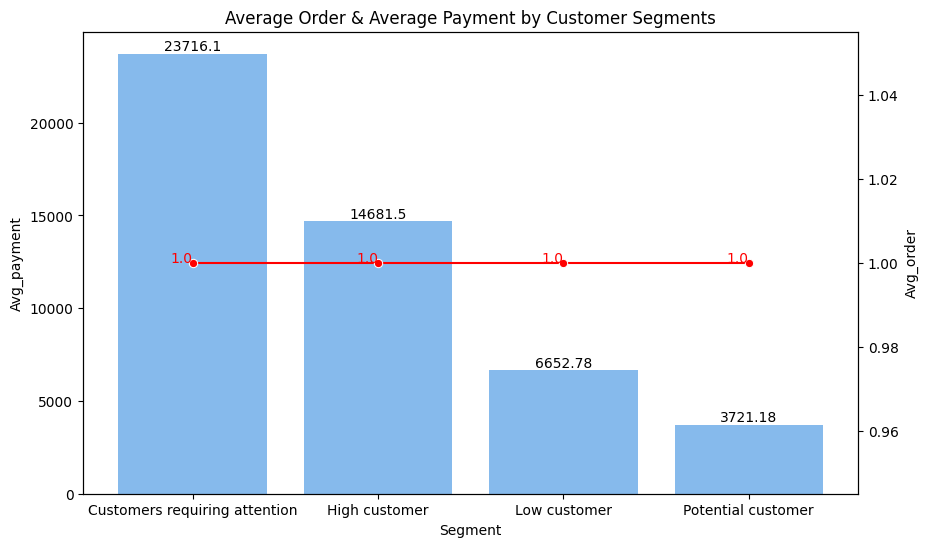

In [ ]:
# Vẽ chart biểu diễn
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
plt.title('Average Order & Average Payment by Customer Segments')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

a = sns.barplot(data=df_avg, x='Segment', y='Avg_payment', ax=ax1,color='xkcd:sky blue')
a.bar_label(a.containers[0],fontsize=10)
sns.lineplot(data=df_avg, x='Segment', y='Avg_order', ax=ax2,color='red',marker='o')
for i in range(df_avg.shape[0]):
  ax2.text(i, df_avg['Avg_order'][i], round(df_avg['Avg_order'][i], 2), fontsize=10, color='red', ha="right")

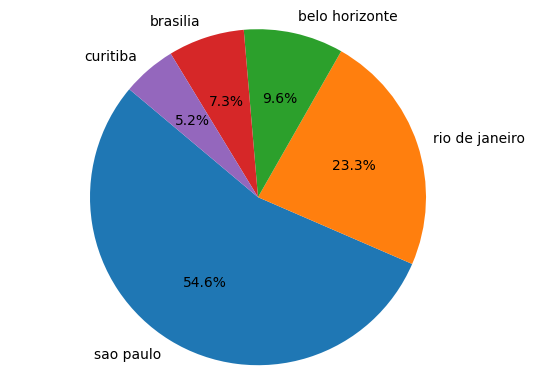

In [ ]:
# Top 5 thành phố có số lượng tệp khách hàng High custome cao nhất
df2 = rfm_df.join(df_customer, how='inner',lsuffix='_x',rsuffix='_y')[['customer_id_x','customer_city','Segment']]
df_city = df2[df2['Segment']=='High customer'].groupby(['Segment','customer_city'])['customer_id_x'].count().reset_index().sort_values(by='customer_id_x',ascending=False).head(5)

# Tạo biểu đồ tròn
plt.pie(df_city.customer_id_x, labels=df_city['customer_city'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Đảm bảo biểu đồ hình tròn hiển thị đúng tỉ lệ
plt.show()

In [8]:
# Tính điểm trung bình mà mỗi tệp khách hàng đánh giá cho dịch vụ của Olist
## Một KH có thể đánh giá đơn hàng với nhiều hơn một số điểm
df3 = pd.merge(rfm_df, df_order, how='left',on='customer_id').merge(df_order_review, how='left', on='order_id')
df_score = df3.groupby('Segment')['review_score'].mean().reset_index()
df_score

,Segment,review_score
0,Customers requiring attention,4.062258
1,High customer,4.088685
2,Low customer,4.110547
3,Potential customer,4.123565


In [ ]:
# Số lượng khách hàng rời bỏ dịch vụ
customer_lost = rfm_df['customer_id'][rfm_df['Segment']=='Low customer'].count()
print('Số lượng khách hàng rời bỏ dịch vụ là:',customer_lost,'người')

Số lượng khách hàng rời bỏ dịch vụ là: 20475 người


#**PHÂN LOẠI KHÁCH HÀNG DỰA VÀO ĐỘ DÀI CHURN**

**Câu 3:** *Nhóm khách hàng có khả năng Churned có đặc điểm như thế nào?*

In [9]:
churn_df = rfm_df[rfm_df['Recency'] > 0].iloc[:,[0,1,2,3,-1]]
# Nhận xét: Hầu hết những khách hàng có độ dài churn dưới 90 ngày đều từng là khách hàng High Customer hoặc Customers requiring attention
churn_df['Churn length'] = None
churn_df['Churn length'][(churn_df['Recency'] <= 7) & (churn_df['Recency'] > 0)] = '7 days'
churn_df['Churn length'][(churn_df['Recency'] <= 14) & (churn_df['Recency'] > 7)] = '14 days'
churn_df['Churn length'][(churn_df['Recency'] <= 30) & (churn_df['Recency'] > 14)] = '30 days'
churn_df['Churn length'][(churn_df['Recency'] <= 45) & (churn_df['Recency'] > 30)] = '45 days'
churn_df['Churn length'][(churn_df['Recency'] <= 60) & (churn_df['Recency'] > 45)] = '60 days'
churn_df['Churn length'][(churn_df['Recency'] <= 90) & (churn_df['Recency'] > 60)] = '90 days'
churn_df['Churn length'][churn_df['Recency'] > 90] = '>90 days'

<ipython-input-9-787e338ecc86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['Churn length'][(churn_df['Recency'] <= 7) & (churn_df['Recency'] > 0)] = '7 days'
<ipython-input-9-787e338ecc86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['Churn length'][(churn_df['Recency'] <= 14) & (churn_df['Recency'] > 7)] = '14 days'
<ipython-input-9-787e338ecc86>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['Chu

In [17]:
# Tính số lượng khách hàng ở mỗi nhóm churn và giá trị giao dịch của họ trước khi churn
churn_df.groupby('Churn length').agg(Count_of_customer = ('customer_id','count'),
                                     Recency = ('Recency','mean'),
                                     Monetary = ('Monetary','sum')). reset_index()


,Churn length,Count_of_customer,Recency,Monetary
0,14 days,1,13.000000,19755
1,30 days,6,22.333333,80962
2,45 days,11,39.727273,371030
3,60 days,1671,56.161580,23386865
4,90 days,8098,74.914176,133469902
5,>90 days,89650,313.728634,1443523730


In [11]:
# Xem xét số lượng và giá trị giao dịch của mỗi tệp khách hàng với độ dài churn khác nhau
churn_df.groupby(['Churn length','Segment']).agg(Recency = ('Recency','mean'),
                                     Monetary = ('Monetary','sum')). reset_index()

,Churn length,Segment,Recency,Monetary
0,14 days,Customers requiring attention,13.000000,19755.0
1,30 days,Customers requiring attention,22.333333,55003.0
2,30 days,High customer,22.333333,25959.0
3,45 days,Customers requiring attention,39.600000,330333.0
4,45 days,High customer,39.833333,40697.0
5,60 days,Customers requiring attention,56.527828,15736589.0
6,60 days,High customer,55.978456,7650276.0
7,90 days,Customers requiring attention,75.065967,99526365.0
8,90 days,High customer,74.807894,33943537.0
9,>90 days,Customers requiring attention,356.472047,773427314.0


**Nhận xét:**
- Nếu khách hàng không mua hàng trong hơn 2 tháng thì có khả năng những khách hàng này sẽ churn
- Nhìn chung, số lượng mà khách hàng churn khá nhiều. Ngoài hai tệp khách hàng High và Requiring Attention đã churn trong hơn 2 tháng qua, còn có thêm nhiều khách hàng thuộc tệp Potential và Low customer đã churn dài hạn.

#**BUSINESS QUESTION**

**Câu 4a:** *Tổng doanh thu mà Olist thu được là bao nhiêu và thay đổi như thế nào theo thời gian?*

**Câu 4b:** *Có bao nhiêu đơn đặt hàng được đặt trên Olist và số lượng các đơn hàng thay đổi như thế nào
theo tháng hoặc mùa?*

In [ ]:
# Tổng doanh thu mà Olist ghi nhận là
Total_revenue = df_join['payment_value'].sum()
print('Tổng doanh thu mà Olist ghi nhận từ tháng 09/2016 đến tháng 10/2018 là:',Total_revenue)

Tổng doanh thu mà Olist ghi nhận từ tháng 09/2016 đến tháng 10/2018 là: 1600883418.0


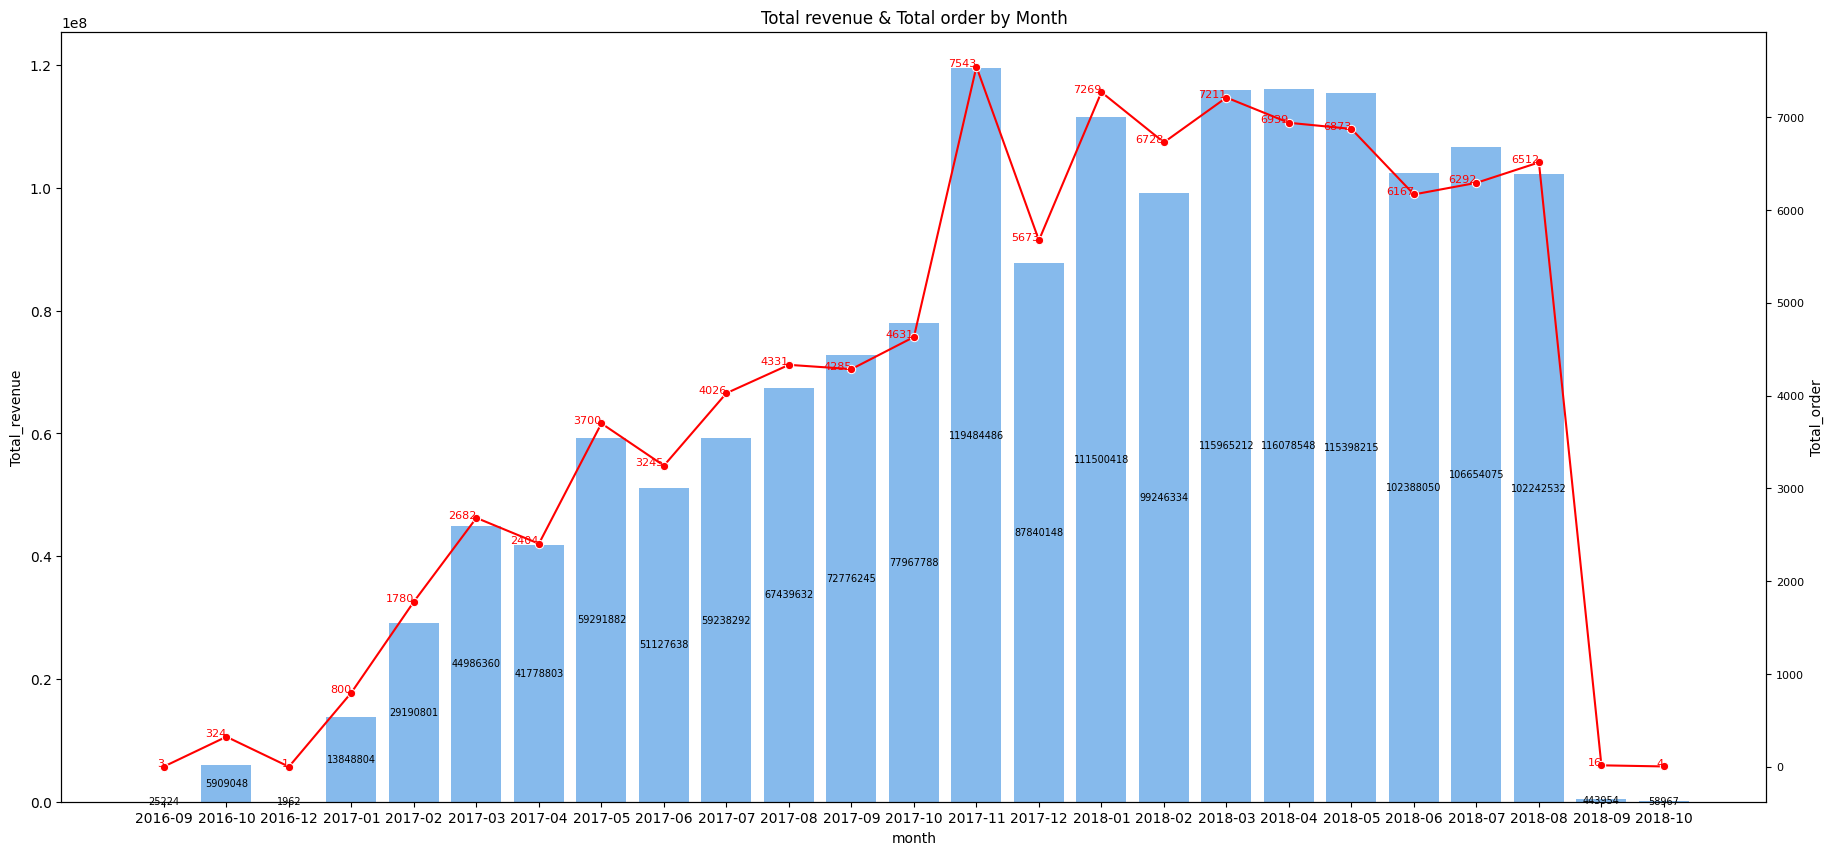

In [18]:
# a. Tổng doanh thu và tổng số đơn hàng mà Olist đạt được là bao nhiêu và thay đổi như thế nào theo thời gian (tháng)?
df_join['month'] = df_join['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_revenue = df_join.groupby('month').agg(Total_revenue = ('payment_value','sum'),
                                          Total_order = ('order_id','nunique')).reset_index()

fig, ax1 = plt.subplots(figsize=(22,10))
ax2 = ax1.twinx()
plt.title('Total revenue & Total order by Month')

plt.xlabel('Month',fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)

c = sns.barplot(data=df_revenue, x='month', y='Total_revenue',ax=ax1,color='xkcd:sky blue')
c.bar_label(c.containers[0],fmt='%.0f',fontsize=7,label_type='center')
sns.lineplot(data=df_revenue, x='month', y='Total_order', ax=ax2,color='red',marker='o')
for i in range(df_revenue.shape[0]):
  ax2.text(i, df_revenue['Total_order'][i], df_revenue['Total_order'][i], fontsize=8, color='red', ha="right")

**Tìm hiểu nguyên nhân vì sao có sự sụt giảm doanh thu được ghi nhận vào 2 tháng cuối (tháng 09 - 10/2018)**

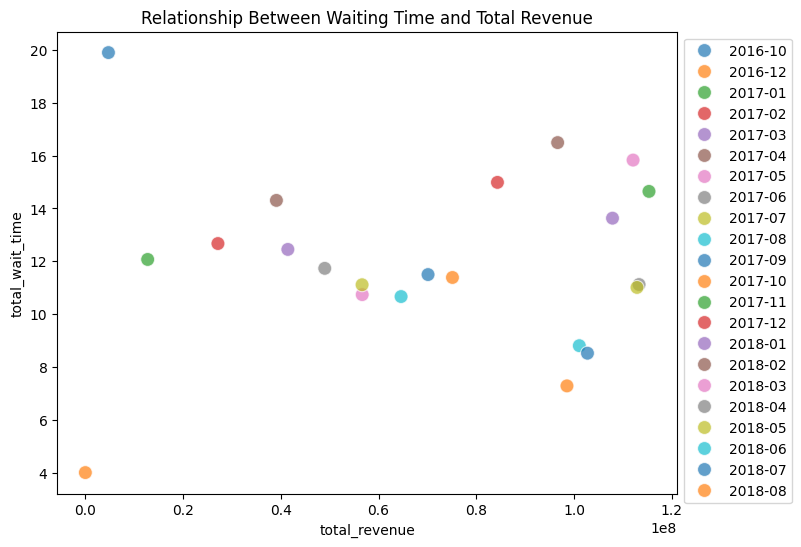

In [22]:
# Ship hàng chậm trễ??
df_join['wait_time'] = (df_join['order_delivered_customer_date'] - df_join['order_purchase_timestamp']).dt.days
df_ship = df_join[df_join['wait_time']>0].groupby('month').agg(
    total_revenue = ('payment_value','sum'),
    total_wait_time = ('wait_time','mean')
).reset_index()
# Vẽ chart
plt.figure(figsize=(8,6))
plt.title('Relationship Between Waiting Time and Total Revenue')
sns.scatterplot(data=df_ship,x='total_revenue',y='total_wait_time',hue='month',palette='tab10', s=100, alpha=0.7)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

**=> Thời gian chờ đợi nhận hàng của khách hàng không phải là nguyên nhân gây ra sự sụt giảm trong doanh thu.**

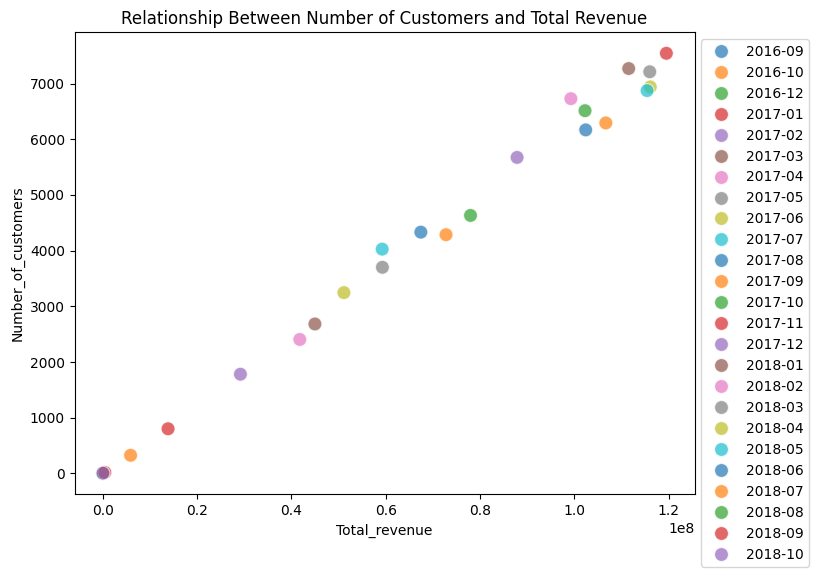

In [26]:
# Do số lượng khách hàng (đơn hàng) mua trong tháng??
df_revenue_cus = df_join.groupby('month').agg(Total_revenue = ('payment_value','sum'),
                                          Number_of_customers = ('customer_id','nunique')).reset_index()
## Vẽ chart
plt.figure(figsize=(8,6))
plt.title('Relationship Between Number of Customers and Total Revenue')
sns.scatterplot(data=df_revenue_cus,x='Total_revenue',y='Number_of_customers',hue='month',palette='tab10', s=100, alpha=0.7)
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

**=> Có mối tương quan thuận biến giữa số lượng khách hàng mua hàng với doanh thu được ghi nhận**

**Khám phá mức độ phân tán trong doanh thu ghi nhận của Olist**

In [ ]:
# Khám phá mức độ biến động doanh thu của Olist trong 3 quý đầu của năm 2017 và 2018
# Chuyển kiểu dữ liệu từ Object sang datetime cho cột month
df_revenue['month']=pd.to_datetime(df_revenue['month'])
df_month = df_revenue[((df_revenue['month'] >= '2017-01-01') & (df_revenue['month'] <= '2017-09-01')) | ((df_revenue['month'] >= '2018-01-01') & (df_revenue['month'] <= '2018-09-01'))]
df_month['Year'] = df_month['month'].dt.strftime('%Y')
df_month['Month'] = df_month['month'].dt.strftime('%m')

<ipython-input-56-e11cbc7b5ee0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['Year'] = df_month['month'].dt.strftime('%Y')
<ipython-input-56-e11cbc7b5ee0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['Month'] = df_month['month'].dt.strftime('%m')


<Axes: title={'center': 'Dispersion of Revenue In The First 3 Quarters of The Year'}, xlabel='Total revenue', ylabel='Year'>

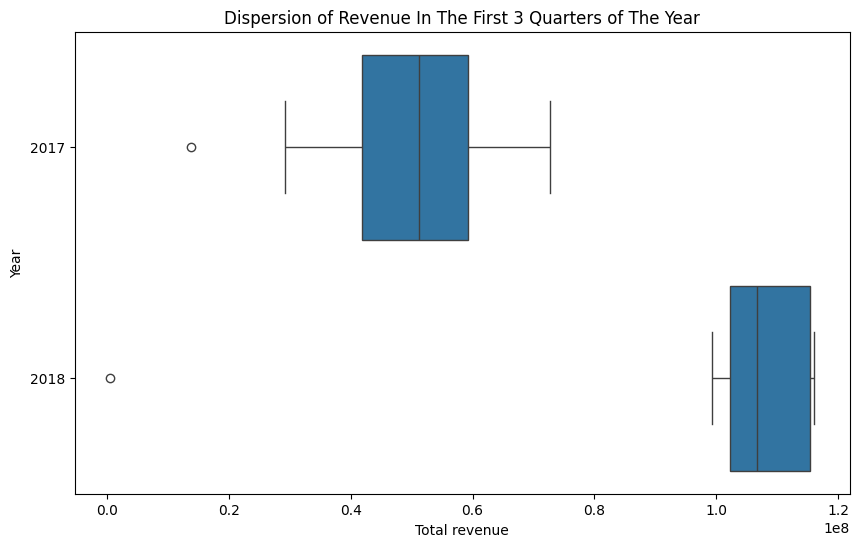

In [ ]:
# Vẽ chart biểu diện độ phân tán của dữ liệu doanh thu 3 quý đầu trong năm 2017 và 2018
plt.figure(figsize=(10,6))
plt.title('Dispersion of Revenue In The First 3 Quarters of The Year')
plt.xlabel('Total revenue')
plt.ylabel('Year')
sns.boxplot(data=df_month,x='Total_revenue',y='Year')

In [ ]:
df_month_pivot = df_month.pivot(index='Year',columns='Month',values='Total_revenue')
df_month_pivot

Month,01,02,03,04,05,06,07,08,09
Year,,,,,,,,,
2017,13848804.0,29190801.0,44986360.0,41778803.0,59291882.0,51127638.0,59238292.0,67439632.0,72776245.0
2018,111500418.0,99246334.0,115965212.0,116078548.0,115398215.0,102388050.0,106654075.0,102242532.0,443954.0


In [ ]:
# Tính mức chênh lệch doanh thu
total_revenue = {}
for i in df_month_pivot.index:
  total_revenue[i] = df_month_pivot.loc[i].sum()

cl = total_revenue['2017'] - total_revenue['2018']
print('Chênh lệch doanh thu 3 quý đầu của năm 2017 và 2018 là:',cl)

Chênh lệch doanh thu 3 quý đầu của năm 2017 và 2018 là: -430238881.0


In [ ]:
# Tính tỷ lệ thay đổi của doanh thu qua các năm
propotion = ((total_revenue['2018']-total_revenue['2017'])/total_revenue['2017']*100).round(2)
if propotion < 0:
  print('Tỷ lệ doanh thu giảm là: ',abs(propotion),'%')
else:
  print('Tỷ lệ doanh thu tăng là: ',abs(propotion),'%')

Tỷ lệ doanh thu tăng là:  97.85 %


In [ ]:
# b. Tổng doanh thu và tổng số đơn hàng mà Olist đạt được là bao nhiêu và thay đổi như thế nào theo thời gian (mùa)?
df_join['Season'] = None
df_join.loc[df_join['order_purchase_timestamp'].dt.strftime('%m').isin(['03','04','05']),'Season'] = 'Mùa xuân'
df_join.loc[df_join['order_purchase_timestamp'].dt.strftime('%m').isin(['06','07','08']),'Season'] = 'Mùa hạ'
df_join.loc[df_join['order_purchase_timestamp'].dt.strftime('%m').isin(['09','10','11']),'Season'] = 'Mùa thu'
df_join.loc[df_join['order_purchase_timestamp'].dt.strftime('%m').isin(['12','01','02']),'Season'] = 'Mùa đông'

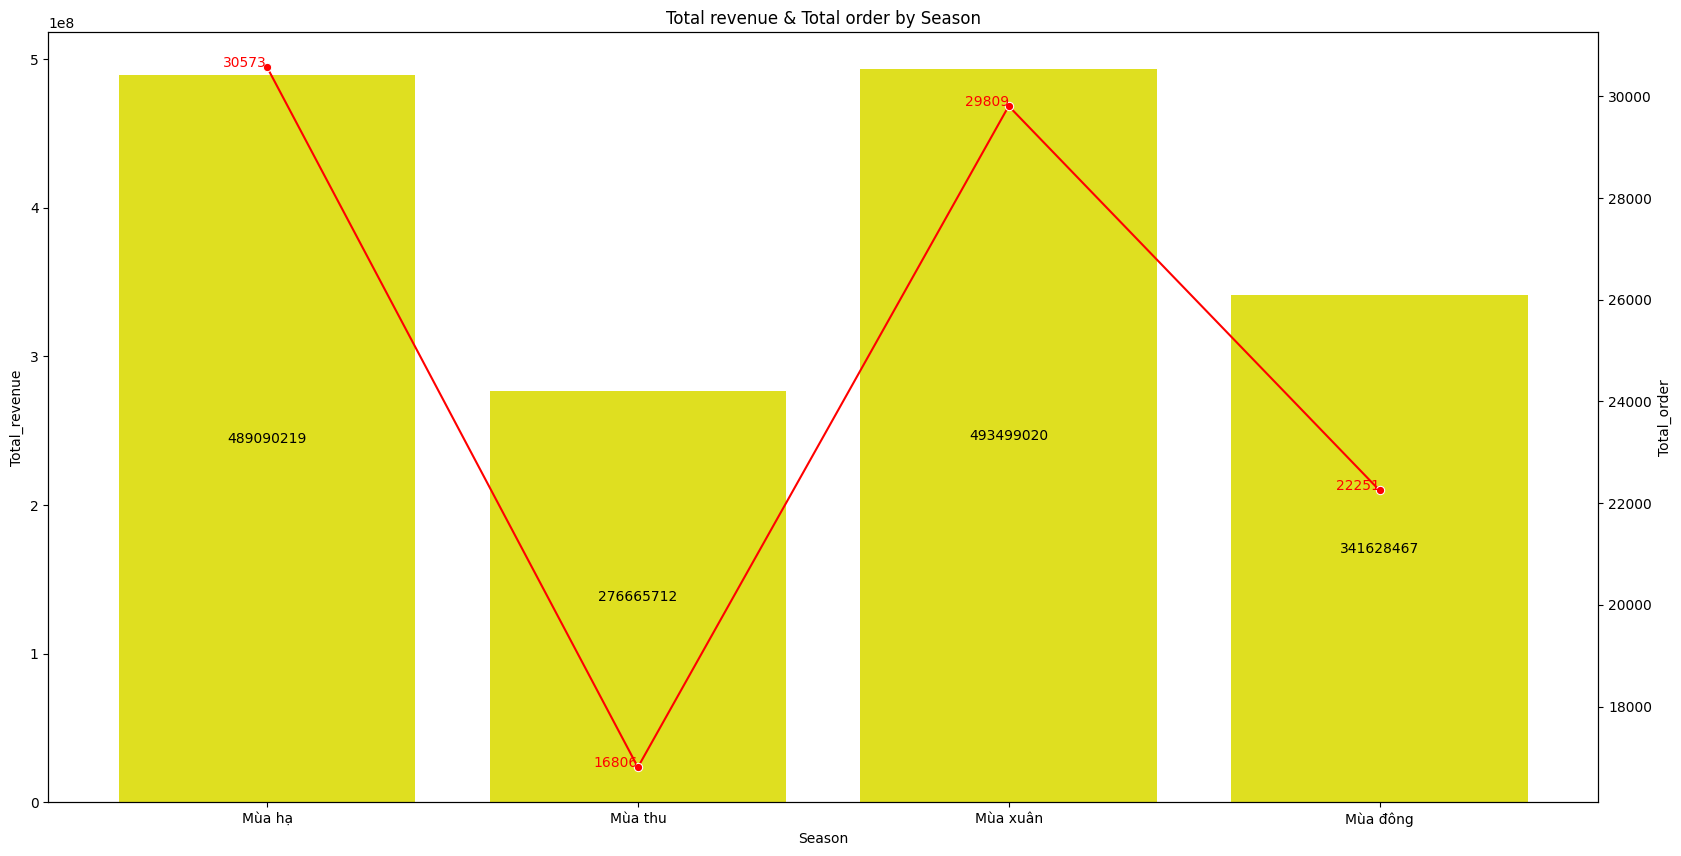

In [ ]:
df_season = df_join.groupby('Season').agg(Total_revenue = ('payment_value','sum'),
                                          Total_order = ('order_id','nunique')).reset_index()

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
plt.title('Total revenue & Total order by Season')

plt.xlabel('Season',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

c = sns.barplot(data=df_season, x='Season', y='Total_revenue',ax=ax1,color='yellow')
c.bar_label(c.containers[0],fmt='%.0f',fontsize=10,label_type='center')
sns.lineplot(data=df_season, x='Season', y='Total_order', ax=ax2,color='red',marker='o')
for i in range(df_season.shape[0]):
  ax2.text(i, df_season['Total_order'][i], df_season['Total_order'][i], fontsize=10, color='red', ha="right")

**Tìm hiểu nguyên nhân vì sao có sự sụt giảm số lượng đơn hàng vào mùa thu**

Quy ước lấy giá trị của giao dịch để tính doanh thu cho sản phẩm

**Câu 4c:** *Các danh mục sản phẩm phổ biến nhất trên Olist là gì và doanh số bán hàng của chúng khác
nhau như thế nào?*

In [ ]:
# Có những order_id được ghi nhận trong df_order_payment nhưng lại không được ghi nhận trong df_order_items
# => Khách hành thanh toán giao dịch vì mua gì đó khác chứ không phải mua sản phẩm???
# Mỗi hóa đơn có thể có nhiều hơn 1 sản phẩm cùng loại
# c. Tìm ra các danh mục sản phẩm phổ biến và doanh số bán của chúng

## Tính Số lượng sản phẩm được bán
df_order_items['count item'] = df_order_items.groupby('product_id')['order_id'].transform('count')

## Tính giá trị của mỗi đơn hàng
df_total_payment = df_order_payment.groupby('order_id')['payment_value'].sum().reset_index()

df_tem = pd.merge(df_order_items,df_total_payment,on='order_id').groupby(['order_id','product_id']).agg(
    count_item = ('count item','mean'),
    total_payment = ('payment_value','mean')
).reset_index()

df_revenue_product = df_tem.groupby('product_id').agg(
    total_item = ('count_item','mean'),
    total_payment = ('total_payment','sum'),
    total_invoice = ('order_id','count')
).reset_index()

In [ ]:
# Merge với bảng df_product (để tính tổng sản phẩm và doanh số theo category) và merge với df_product_category_name_translation (để chuyển thành tên tiếng Anh)
# Tìm ra sản top10 sản phẩm phổ biến nhất bằng cách dựa vào số lượng mà sản phẩm đó bán được
top10_popular = df_revenue_product.merge(df_product,on='product_id').groupby('product_category_name').agg(
    total_amount = ('total_item','sum'),
    revenue = ('total_payment','sum')
).reset_index().merge(df_product_category_name_translation,on='product_category_name').sort_values(by='total_amount',ascending=False).head(10)

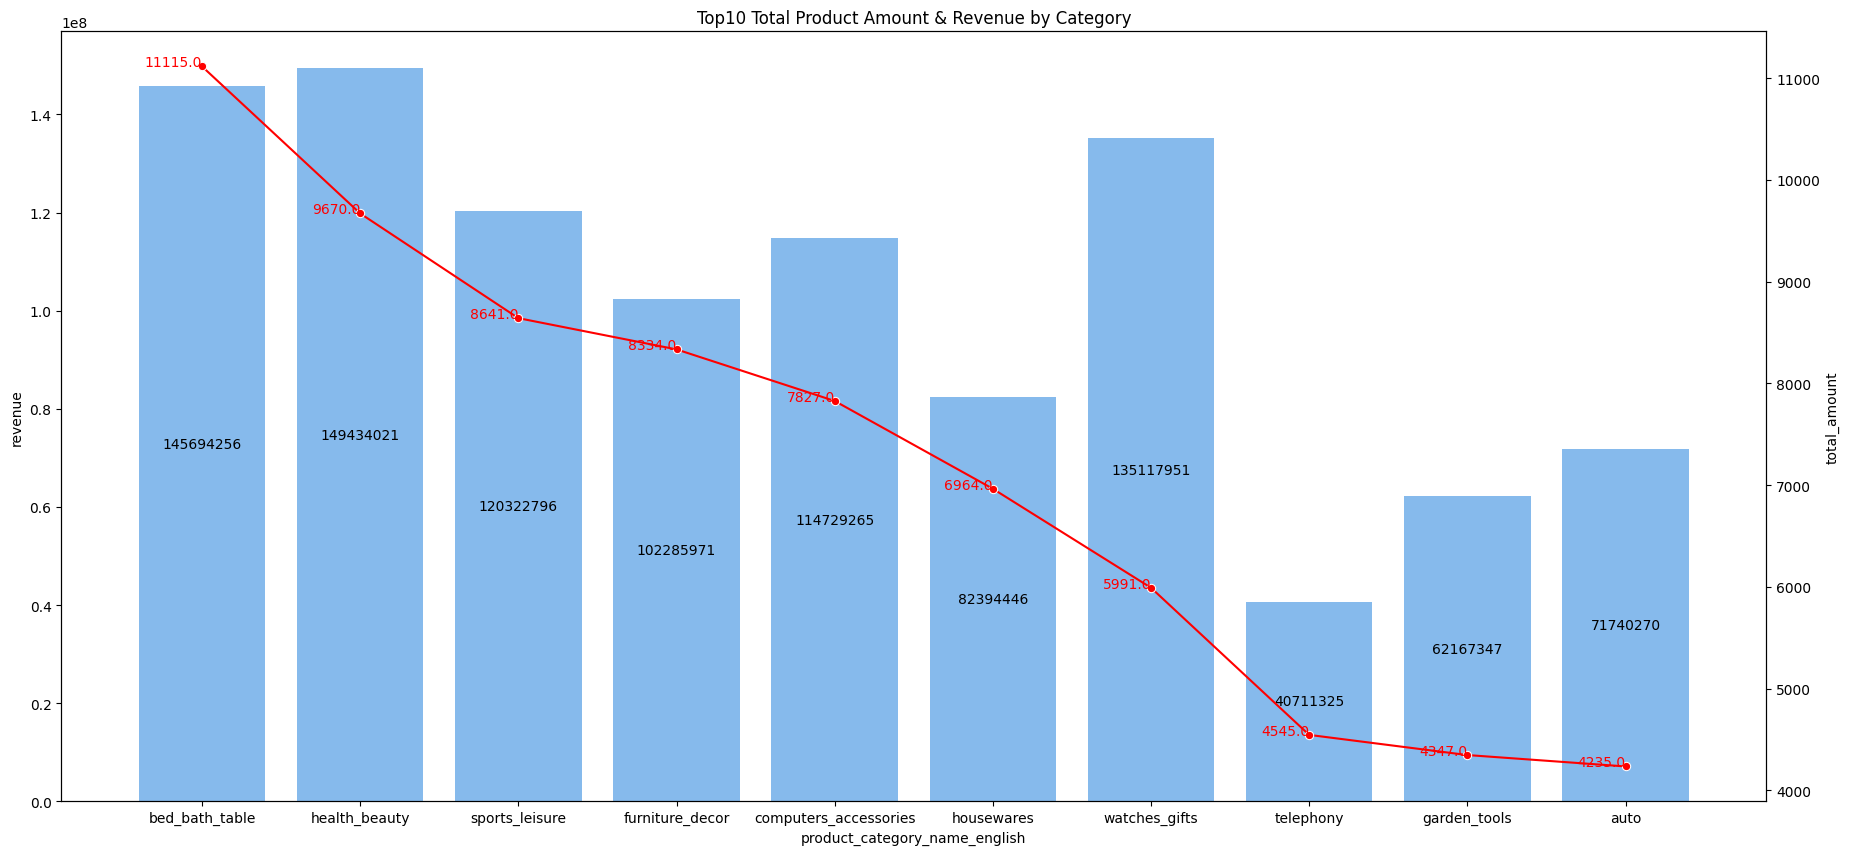

In [ ]:
# Vẽ chart cho câu c
fig, ax1 = plt.subplots(figsize=(22,10))
ax2 = ax1.twinx()
plt.title('Top10 Total Product Amount & Revenue by Category')

plt.xlabel('Category',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

c = sns.barplot(data=top10_popular, x='product_category_name_english', y='revenue',ax=ax1,color='xkcd:sky blue')
c.bar_label(c.containers[0],fmt='%.0f',fontsize=10,label_type='center')
sns.lineplot(data=top10_popular, x='product_category_name_english', y='total_amount', ax=ax2,color='red',marker='o')
x = top10_popular.index
for i in range(len(x)):
  ax2.text(i, top10_popular['total_amount'][x[i]], top10_popular['total_amount'][x[i]], fontsize=10, color='red', ha="right")

**Câu 4d:** *Giá trị Average Order Value (AOV) trên Olist là bao nhiêu và giá trị này thay đổi như thế nào
theo Product Category hoặc Payment Method?*

In [ ]:
# Giá trị Average Order Value (AOV) trên Olist
olist_aov = ((df_join['payment_value'].sum()) / (df_join['order_id'].nunique())).round(2)
print('Giá trị Average Order Value (AOV) trên Olist là:',olist_aov)

Giá trị Average Order Value (AOV) trên Olist là: 16099.15


In [ ]:
## Merge với bảng df_product (để tính tổng số hóa đơn và doanh số theo category) và merge với df_product_category_name_translation (để chuyển thành tên tiếng Anh)
## Theo Product Category
df_aov_product = df_revenue_product.merge(df_product,on='product_id').groupby('product_category_name').agg(
    total_invoice = ('total_invoice','sum'),
    revenue = ('total_payment','sum')
).reset_index().merge(df_product_category_name_translation,on='product_category_name')

df_aov_product['AOV'] = (df_aov_product['revenue'] / df_aov_product['total_invoice']).round(2)

df_aov_product

,product_category_name,total_invoice,revenue,product_category_name_english,AOV
0,agro_industria_e_comercio,183,7883534.0,agro_industry_and_commerce,43079.42
1,alimentos,453,3817671.0,food,8427.53
2,alimentos_bebidas,234,2112353.0,food_drink,9027.15
3,artes,202,2881593.0,art,14265.31
4,artes_e_artesanato,24,232617.0,arts_and_craftmanship,9692.38
...,...,...,...,...,...
66,sinalizacao_e_seguranca,143,3167294.0,signaling_and_security,22148.91
67,tablets_impressao_imagem,79,921791.0,tablets_printing_image,11668.24
68,telefonia,4287,40711325.0,telephony,9496.46
69,telefonia_fixa,217,6432926.0,fixed_telephony,29644.82


In [ ]:
# Top 10 danh mục sản phẩm được khách hàng chi tiêu nhiều trên mỗi hóa đơn mua hàng
df_aov_product.sort_values(by='AOV',ascending=False).head(10)

,product_category_name,total_invoice,revenue,product_category_name_english,AOV
60,pcs,181,23293757.0,computers,128694.79
63,portateis_casa_forno_e_cafe,76,5122932.0,small_appliances_home_oven_and_coffee,67407.00
29,eletrodomesticos_2,234,12396092.0,home_appliances_2,52974.75
0,agro_industria_e_comercio,183,7883534.0,agro_industry_and_commerce,43079.42
45,instrumentos_musicais,636,21413212.0,musical_instruments,33668.57
31,eletroportateis,632,20905441.0,small_appliances,33078.23
69,telefonia_fixa,217,6432926.0,fixed_telephony,29644.82
25,construcao_ferramentas_seguranca,169,4773316.0,construction_tools_safety,28244.47
55,moveis_escritorio,1303,36431954.0,office_furniture,27960.06
56,moveis_quarto,95,2484628.0,furniture_bedroom,26153.98


In [ ]:
## Theo Payment Method
df_aov_payment = df_order_payment.groupby('payment_type').agg(
    revenue = ('payment_value','sum'),
    total_invoice = ('order_id','nunique')
).reset_index()

df_aov_payment['revenue'] = df_aov_payment['revenue'].astype(int)

df_aov_payment['AOV'] = (df_aov_payment['revenue'] / df_aov_payment['total_invoice']).round(2)

df_aov_payment

,payment_type,revenue,total_invoice,AOV
0,boleto,286936127,19784,14503.44
1,credit_card,1254208419,76505,16393.81
2,debit_card,21798979,1528,14266.35
3,not_defined,0,3,0.00
4,voucher,37943687,3866,9814.71
